In [2]:

import pandas as pd
import numpy as np
from jeffutils.utils import set_np_pd_display_params, print_display, movecol, str_to_list_py
import os
import matplotlib.pyplot as plt
from itertools import product
from sklearn.neighbors import KernelDensity
from collections import defaultdict
from tqdm.auto import tqdm
from random import choice
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import pickle
from scipy.stats import entropy, wasserstein_distance, pearsonr
import json
from copy import deepcopy

from py_files.data_manager import RELEVANT_COLUMNS, EVENTS_IGNORED, load_and_clean_csv
from py_files.helper_funcs import get_data, get_label_encoder

set_np_pd_display_params(np, pd)
# set max rows for pandas dataframe to 100
pd.set_option("display.max_rows", 100)

DATA_PATH = "data/play_by_play/"

# load test_game_ids.txt

In [2]:
with open("data/test_game_ids.txt", 'r') as f:
    test_game_ids_str = f.read()
test_game_ids_str = str_to_list_py(test_game_ids_str)

[2023020750, 2023020766, 2023020368, 2023020639, 2023020692, 2023020771, 2023020970, 2023020527, 2023020960, 2023020546, 2023020725, 2023020801, 2023020666, 2023020441, 2023020285, 2023020382, 2023020236, 2023020890, 2023020929, 2023020858, 2023020415, 2023020227, 2023020780, 2023020308, 2023020605, 2023020743, 2023020641, 2023020895, 2023020637, 2023020137, 2023020617, 2023020430, 2023020842, 2023020025, 2023020173, 2023020101, 2023020119, 2023020968, 2023020816, 2023020700, 2023020428, 2023021065, 2023020787, 2023020534, 2023020959, 2023020250, 2023020166, 2023020812, 2023020835, 2023020161, 2023020231, 2023020782, 2023020628, 2023020472, 2023020973, 2023020621, 2023020905, 2023020228, 2023020656, 2023020184, 2023020219, 2023020160, 2023020949, 2023020305, 2023020875, 2023020283, 2023020862, 2023020675, 2023020293, 2023020714, 2023020446, 2023021044, 2023020784, 2023020811, 2023020796, 2023020578, 2023020095, 2023021004, 2023020789, 2023020682, 2023020663, 2023020730, 2023020181, 202

# finding test set

In [7]:
df_full = pd.read_feather("data/play_by_play/play_by_play_full_state_space.feather")
print_display('df_full', globals(), 10)

Name: df_full


,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters,order,STATE_BLOCKED_SHOT_AWAY,STATE_BLOCKED_SHOT_HOME,STATE_FACEOFF_AWAY,STATE_FACEOFF_HOME,STATE_GIVEAWAY_AWAY,STATE_GIVEAWAY_HOME,STATE_GOAL_AWAY,STATE_GOAL_HOME,STATE_MISSED_SHOT_AWAY,STATE_MISSED_SHOT_HOME,STATE_PENALTY_AWAY,STATE_PENALTY_HOME,STATE_SHOT_AWAY,STATE_SHOT_HOME,STATE_TAKEAWAY_AWAY,STATE_TAKEAWAY_HOME
0,2010-10-07,2010-10-07T23:29:40Z,2010020001,Toronto Maple Leafs,Montreal Canadiens,FACEOFF_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,0,1200.0000000,0,3600,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010-10-07,2010-10-07T23:30:52Z,2010020001,Toronto Maple Leafs,Montreal Canadiens,GIVEAWAY_HOME,-,0.0000000,Toronto Maple Leafs,home,REGULAR,1,69,1131.0000000,69,3531,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2010-10-07,2010-10-07T23:30:56Z,2010020001,Toronto Maple Leafs,Montreal Canadiens,BLOCKED_SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,73,1127.0000000,73,3527,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,2010-10-07,2010-10-07T23:31:09Z,2010020001,Toronto Maple Leafs,Montreal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,86,1114.0000000,86,3514,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,3,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2010-10-07,2010-10-07T23:31:14Z,2010020001,Toronto Maple Leafs,Montreal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,91,1109.0000000,91,3509,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,4,1,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3712181,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,BLOCKED_SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1155,45.0000000,3555,45,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712181,15,22,17,31,5,10,2,1,10,21,1,1,22,19,1,6
3712182,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1185,15.0000000,3585,15,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712182,15,22,17,31,5,10,2,1,10,21,1,1,22,20,1,6
3712183,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1186,14.0000000,3586,14,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712183,15,22,17,31,5,10,2,1,10,21,1,1,22,21,1,6
3712184,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,FACEOFF_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1187,13.0000000,3587,13,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712184,15,22,17,32,5,10,2,1,10,21,1,1,22,21,1,6


3712186x44


In [9]:
df = df_full.copy()
df['game_date'] = pd.to_datetime(df['game_date'])

# get the training dataframe as all game_dates between 2018-10-01 to 2023-10-01
df_train = df[df['game_date'].between('2018-10-01', '2023-09-30')]
# get the test dataframe from 2023-10-01 to the end
df_test = df[df['game_date'] >= '2023-10-01']

print_display('df_train', globals(), 10)
print_display('df_test', globals(), 10)

Name: df_train


,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters,order,STATE_BLOCKED_SHOT_AWAY,STATE_BLOCKED_SHOT_HOME,STATE_FACEOFF_AWAY,STATE_FACEOFF_HOME,STATE_GIVEAWAY_AWAY,STATE_GIVEAWAY_HOME,STATE_GOAL_AWAY,STATE_GOAL_HOME,STATE_MISSED_SHOT_AWAY,STATE_MISSED_SHOT_HOME,STATE_PENALTY_AWAY,STATE_PENALTY_HOME,STATE_SHOT_AWAY,STATE_SHOT_HOME,STATE_TAKEAWAY_AWAY,STATE_TAKEAWAY_HOME
2136202,2018-10-03 00:00:00,2018-10-03T23:16:14Z,2018020001,Toronto Maple Leafs,Montreal Canadiens,FACEOFF_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,0,1200.0000000,0,3600,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,2136202,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2136203,2018-10-03 00:00:00,2018-10-03T23:18:00Z,2018020001,Toronto Maple Leafs,Montreal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,29,1171.0000000,29,3571,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,2136203,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2136204,2018-10-03 00:00:00,2018-10-03T23:18:20Z,2018020001,Toronto Maple Leafs,Montreal Canadiens,SHOT_HOME,-,0.0000000,Toronto Maple Leafs,home,REGULAR,1,49,1151.0000000,49,3551,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,2136204,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
2136205,2018-10-03 00:00:00,2018-10-03T23:18:31Z,2018020001,Toronto Maple Leafs,Montreal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,60,1140.0000000,60,3540,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,2136205,0,0,1,0,0,0,0,0,0,0,0,0,2,1,0,0
2136206,2018-10-03 00:00:00,2018-10-03T23:18:52Z,2018020001,Toronto Maple Leafs,Montreal Canadiens,FACEOFF_HOME,-,0.0000000,Toronto Maple Leafs,home,REGULAR,1,61,1139.0000000,61,3539,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,2136206,0,0,1,1,0,0,0,0,0,0,0,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3480197,2023-06-13 00:00:00,2023-06-14T02:53:32Z,2022030415,Vegas Golden Knights,Florida Panthers,FACEOFF_HOME,-,0.0000000,Vegas Golden Knights,home,REGULAR,3,1127,73.0000000,3527,73,8,3,9.0000000,3.0000000,5v5,EV,Even,-,False,5,5,3480197,26,11,30,36,14,23,3,8,15,20,1,1,32,22,7,14
3480198,2023-06-13 00:00:00,2023-06-14T02:53:36Z,2022030415,Vegas Golden Knights,Florida Panthers,BLOCKED_SHOT_HOME,-,0.0000000,Vegas Golden Knights,home,REGULAR,3,1131,69.0000000,3531,69,8,3,9.0000000,3.0000000,5v5,EV,Even,-,False,5,5,3480198,26,12,30,36,14,23,3,8,15,20,1,1,32,22,7,14
3480199,2023-06-13 00:00:00,2023-06-14T02:53:40Z,2022030415,Vegas Golden Knights,Florida Panthers,SHOT_HOME,-,0.0000000,Vegas Golden Knights,home,REGULAR,3,1135,65.0000000,3535,65,8,3,9.0000000,3.0000000,5v5,EV,Even,-,False,5,5,3480199,26,12,30,36,14,23,3,8,15,20,1,1,32,23,7,14
3480200,2023-06-13 00:00:00,2023-06-14T02:53:43Z,2022030415,Vegas Golden Knights,Florida Panthers,GOAL_HOME,-,0.0000000,Vegas Golden Knights,home,REGULAR,3,1138,62.0000000,3538,62,9,3,9.0000000,3.0000000,5v5,EV,Even,False,False,5,5,3480200,26,12,30,36,14,23,3,9,15,20,1,1,32,23,7,14


1344000x44
Name: df_test


,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters,order,STATE_BLOCKED_SHOT_AWAY,STATE_BLOCKED_SHOT_HOME,STATE_FACEOFF_AWAY,STATE_FACEOFF_HOME,STATE_GIVEAWAY_AWAY,STATE_GIVEAWAY_HOME,STATE_GOAL_AWAY,STATE_GOAL_HOME,STATE_MISSED_SHOT_AWAY,STATE_MISSED_SHOT_HOME,STATE_PENALTY_AWAY,STATE_PENALTY_HOME,STATE_SHOT_AWAY,STATE_SHOT_HOME,STATE_TAKEAWAY_AWAY,STATE_TAKEAWAY_HOME
3480202,2023-10-10 00:00:00,2023-10-10,2023020001,Tampa Bay Lightning,Nashville Predators,FACEOFF_AWAY,-,0.0000000,Nashville Predators,away,REGULAR,1,0,1200.0000000,0,3600,0,0,5.0000000,3.0000000,5v5,EV,Even,False,False,5,5,3480202,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3480203,2023-10-10 00:00:00,2023-10-10,2023020001,Tampa Bay Lightning,Nashville Predators,FACEOFF_HOME,-,0.0000000,Tampa Bay Lightning,home,REGULAR,1,35,1165.0000000,35,3565,0,0,5.0000000,3.0000000,5v5,EV,Even,False,False,5,5,3480203,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3480204,2023-10-10 00:00:00,2023-10-10,2023020001,Tampa Bay Lightning,Nashville Predators,GIVEAWAY_AWAY,-,0.0000000,Nashville Predators,away,REGULAR,1,58,1142.0000000,58,3542,0,0,5.0000000,3.0000000,5v5,EV,Even,False,False,5,5,3480204,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
3480205,2023-10-10 00:00:00,2023-10-10,2023020001,Tampa Bay Lightning,Nashville Predators,SHOT_HOME,-,0.0000000,Tampa Bay Lightning,home,REGULAR,1,61,1139.0000000,61,3539,0,0,5.0000000,3.0000000,5v5,EV,Even,False,False,5,5,3480205,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0
3480206,2023-10-10 00:00:00,2023-10-10,2023020001,Tampa Bay Lightning,Nashville Predators,SHOT_HOME,-,0.0000000,Tampa Bay Lightning,home,REGULAR,1,70,1130.0000000,70,3530,0,0,5.0000000,3.0000000,5v5,EV,Even,False,False,5,5,3480206,0,0,1,1,1,0,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3712181,2024-03-16 00:00:00,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,BLOCKED_SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1155,45.0000000,3555,45,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712181,15,22,17,31,5,10,2,1,10,21,1,1,22,19,1,6
3712182,2024-03-16 00:00:00,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1185,15.0000000,3585,15,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712182,15,22,17,31,5,10,2,1,10,21,1,1,22,20,1,6
3712183,2024-03-16 00:00:00,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1186,14.0000000,3586,14,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712183,15,22,17,31,5,10,2,1,10,21,1,1,22,21,1,6
3712184,2024-03-16 00:00:00,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,FACEOFF_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1187,13.0000000,3587,13,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712184,15,22,17,32,5,10,2,1,10,21,1,1,22,21,1,6


231984x44


In [10]:
print(len(df_test['game_id'].unique()))

1072


In [52]:
df = df_test.copy()
df = df.sort_values(by=['game_date', 'game_id'], ascending=[True, True])
last_rows = df['game_id'].shift(-1) != df['game_id']
df = df.loc[last_rows, :]
df = df.loc[~(df['home_final'] == df['away_final']), :]
df['home_won'] = df['home_final'] > df['away_final']

TOTAL = 100
home_wins = TOTAL // 2
away_wins = TOTAL - home_wins

teams = df['home_name'].unique()
#teams = [t for t in teams if 'blue' not in t.lower() and 'devil' not in t.lower()]

test_game_ids = []
home_winners = df.loc[df['home_won'] == True, :]
home_count = 0

i = 0
while home_count < home_wins:
    team = teams[i]
    curr_df = home_winners.loc[
        (home_winners['home_name'] == team) & 
        (~home_winners['game_id'].isin(test_game_ids)), :]
    if len(curr_df) == 0:
        print("Empty")
        i = (i + 1) % len(teams)
        continue
    game_id = choice(curr_df['game_id'].unique())
    test_game_ids.append(game_id)
    home_count += 1
    i = (i + 1) % len(teams)

away_winners = df.loc[df['home_won'] == False, :]
away_count = 0
while away_count < away_wins:
    team = teams[i]
    curr_df = away_winners.loc[
        (away_winners['home_name'] == team) & 
        (~away_winners['game_id'].isin(test_game_ids)), :]
    if len(curr_df) == 0:
        print("Empty")
        i = (i + 1) % len(teams)
        continue
    game_id = choice(curr_df['game_id'].unique())
    test_game_ids.append(game_id)
    away_count += 1
    i = (i + 1) % len(teams)
    
print(test_game_ids)
print(len(test_game_ids))


[2023020750, 2023020766, 2023020368, 2023020639, 2023020692, 2023020771, 2023020970, 2023020527, 2023020960, 2023020546, 2023020725, 2023020801, 2023020666, 2023020441, 2023020285, 2023020382, 2023020236, 2023020890, 2023020929, 2023020858, 2023020415, 2023020227, 2023020780, 2023020308, 2023020605, 2023020743, 2023020641, 2023020895, 2023020637, 2023020137, 2023020617, 2023020430, 2023020842, 2023020025, 2023020173, 2023020101, 2023020119, 2023020968, 2023020816, 2023020700, 2023020428, 2023021065, 2023020787, 2023020534, 2023020959, 2023020250, 2023020166, 2023020812, 2023020835, 2023020161, 2023020231, 2023020782, 2023020628, 2023020472, 2023020973, 2023020621, 2023020905, 2023020228, 2023020656, 2023020184, 2023020219, 2023020160, 2023020949, 2023020305, 2023020875, 2023020283, 2023020862, 2023020675, 2023020293, 2023020714, 2023020446, 2023021044, 2023020784, 2023020811, 2023020796, 2023020578, 2023020095, 2023021004, 2023020789, 2023020682, 2023020663, 2023020730, 2023020181, 202

100


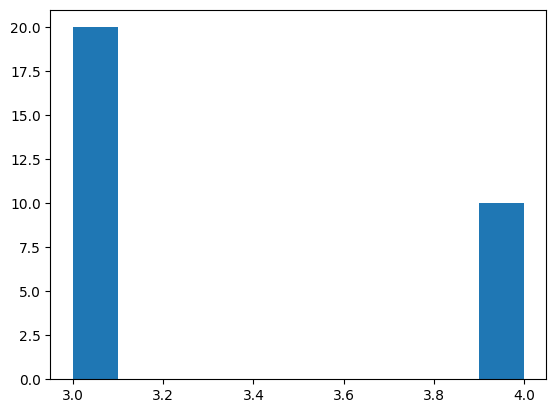

home_name
Anaheim Ducks           3
Arizona Coyotes         3
Boston Bruins           4
Buffalo Sabres          4
Calgary Flames          4
Carolina Hurricanes     4
Chicago Blackhawks      3
Colorado Avalanche      3
Dallas Stars            3
Detroit Red Wings       3
Edmonton Oilers         3
Florida Panthers        3
Los Angeles Kings       4
Minnesota Wild          3
Montreal Canadiens      3
Nashville Predators     3
New Jersey Devils       4
New York Islanders      3
New York Rangers        3
Ottawa Senators         3
Philadelphia Flyers     3
Pittsburgh Penguins     4
San Jose Sharks         3
Seattle Kraken          3
Tampa Bay Lightning     4
Toronto Maple Leafs     3
Vancouver Canucks       4
Vegas Golden Knights    4
Washington Capitals     3
Winnipeg Jets           3
dtype: int64

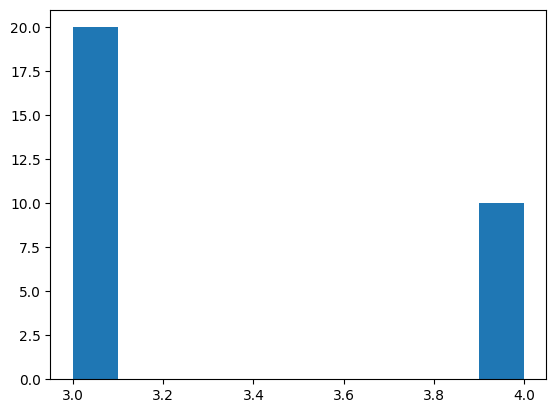

home_name
Anaheim Ducks           3
Arizona Coyotes         3
Boston Bruins           4
Buffalo Sabres          4
Calgary Flames          4
Carolina Hurricanes     4
Chicago Blackhawks      3
Colorado Avalanche      3
Dallas Stars            3
Detroit Red Wings       3
Edmonton Oilers         3
Florida Panthers        3
Los Angeles Kings       4
Minnesota Wild          3
Montreal Canadiens      3
Nashville Predators     3
New Jersey Devils       4
New York Islanders      3
New York Rangers        3
Ottawa Senators         3
Philadelphia Flyers     3
Pittsburgh Penguins     4
San Jose Sharks         3
Seattle Kraken          3
Tampa Bay Lightning     4
Toronto Maple Leafs     3
Vancouver Canucks       4
Vegas Golden Knights    4
Washington Capitals     3
Winnipeg Jets           3
dtype: int64

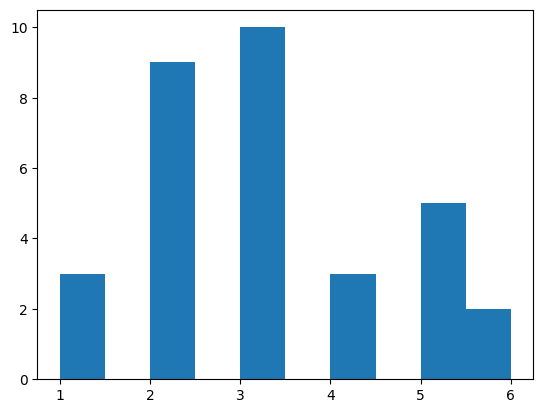

away_name
Anaheim Ducks            5
Arizona Coyotes          3
Boston Bruins            2
Buffalo Sabres           3
Calgary Flames           5
Carolina Hurricanes      4
Chicago Blackhawks       3
Colorado Avalanche       2
Columbus Blue Jackets    2
Dallas Stars             2
Detroit Red Wings        2
Edmonton Oilers          5
Florida Panthers         3
Los Angeles Kings        4
Minnesota Wild           6
Montreal Canadiens       1
Nashville Predators      3
New Jersey Devils        3
New York Islanders       1
New York Rangers         6
Ottawa Senators          3
Philadelphia Flyers      1
Pittsburgh Penguins      5
San Jose Sharks          4
Seattle Kraken           2
St. Louis Blues          3
Tampa Bay Lightning      2
Toronto Maple Leafs      3
Vancouver Canucks        2
Vegas Golden Knights     2
Washington Capitals      5
Winnipeg Jets            3
dtype: int64

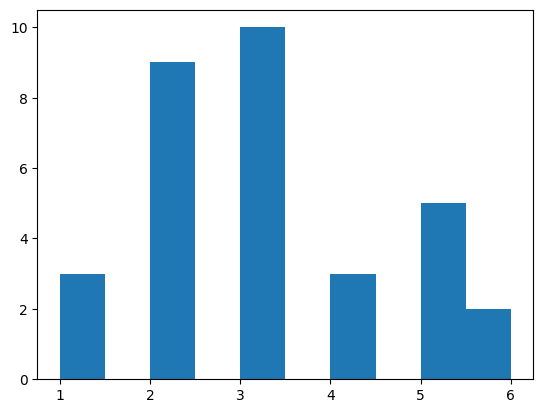

away_name
Anaheim Ducks            5
Arizona Coyotes          3
Boston Bruins            2
Buffalo Sabres           3
Calgary Flames           5
Carolina Hurricanes      4
Chicago Blackhawks       3
Colorado Avalanche       2
Columbus Blue Jackets    2
Dallas Stars             2
Detroit Red Wings        2
Edmonton Oilers          5
Florida Panthers         3
Los Angeles Kings        4
Minnesota Wild           6
Montreal Canadiens       1
Nashville Predators      3
New Jersey Devils        3
New York Islanders       1
New York Rangers         6
Ottawa Senators          3
Philadelphia Flyers      1
Pittsburgh Penguins      5
San Jose Sharks          4
Seattle Kraken           2
St. Louis Blues          3
Tampa Bay Lightning      2
Toronto Maple Leafs      3
Vancouver Canucks        2
Vegas Golden Knights     2
Washington Capitals      5
Winnipeg Jets            3
dtype: int64

50
50
0


In [48]:
df = df_test.loc[df_test['game_id'].isin(test_game_ids), :].copy()
last_rows = df['game_id'].shift(-1) != df['game_id']
df = df.loc[last_rows, :]
print(len(df))
team_counts = df.groupby('home_name').size()
plt.hist(team_counts)
plt.show()
display(team_counts)
team_counts = df.groupby('home_name').size()
plt.hist(team_counts)
plt.show()
display(team_counts)
team_counts = df.groupby('away_name').size()
plt.hist(team_counts)
plt.show()
display(team_counts)
team_counts = df.groupby('away_name').size()
plt.hist(team_counts)
plt.show()
display(team_counts)
print(len(df.loc[df['home_final'] > df['away_final'], 'game_id'].unique()))
print(len(df.loc[df['home_final'] < df['away_final'], 'game_id'].unique()))
print(len(df.loc[df['home_final'] == df['away_final'], 'game_id'].unique()))

In [53]:
with open("data/test_game_ids.txt", "w+") as file:
    inner = ", ".join([str(x) for x in test_game_ids])
    file.write(f"[{inner}]")

# comparing accuracies

In [24]:
df_full = pd.read_feather("data/play_by_play/play_by_play_full_state_space.feather")

In [25]:
game_ids = [2022020839, 2023020412, 2022020727, 2022030154, 
    2022021296, 2023020164, 2022020793, 2023020317, 
    2022020971, 2022030145, 2022020938, 2022021300, 
    2022021101, 2022020747, 2023020254, 2022020832, 
    2022020842, 2022021012, 2023020268, 2022020867, 
    2022030324, 2023020546, 2022021001, 2022021055, 
    2023020464, 2022021181, 2023020096, 2022020688, 
    2023020325, 2022021166, 2022020932, 2022020843, 
    2023020365, 2022030245, 2022021040, 2022021088, 
    2023020570, 2023020264, 2023020129, 2022020876, 
    2023020292, 2023020010, 2022021270, 2022021115, 
    2022020753, 2023020475, 2023020192, 2022020662, 
    2023020033, 2023020482]

with open("data/test_game_ids.txt", 'r') as f:
    test_game_ids_str = f.read()
game_ids = str_to_list_py(test_game_ids_str)

dfs = []
for game_id in game_ids:
    path = f"data/pickles/simulation_probs_{game_id}.pickle"
    with open(path, "rb") as f:
        data = pickle.load(f)
    game_id = data['game_id']
    curr_game = data['curr_game'].reset_index(drop=True)
    rows_to_simulate = data['rows_to_simulate']
    simulation_probabilities = data['simulation_probabilities']
    home_probs = [x[0] for x in simulation_probabilities]
    
    df = curr_game.loc[rows_to_simulate, ['game_id', 'game_seconds']].copy()
    df['probability_home'] = home_probs
    dfs.append(df)
    
mcmc_df = pd.concat(dfs, ignore_index=True).reset_index(drop=True)
mcmc_df = mcmc_df.sort_values(by=['game_id', 'game_seconds']).reset_index(drop=True)

In [26]:
# load in the bayesian and xgboost probabilities
bayesian_df = pd.read_feather("data/predictions/bayesian_outcomes2.feather")
bayesian_df = bayesian_df.rename(columns={
    "time_remaining": "game_seconds",
    "home_team_win_probability": "probability_home"})
bayesian_df['game_seconds'] = 3600 - bayesian_df['game_seconds']
bayesian_df = bayesian_df.sort_values(by=['game_id', 'game_seconds']).reset_index(drop=True)

xgboost_df = pd.read_feather("data/predictions/xgboost_results_df (2).feather")
xgboost_df = xgboost_df.sort_values(by=['game_id', 'game_seconds']).reset_index(drop=True)

# find the game_ids that all of the dataframes have in common
bayesian_game_ids = bayesian_df['game_id'].unique()
xgboost_game_ids = xgboost_df['game_id'].unique()

selected_game_ids = mcmc_df['game_id'].unique()
selected_game_ids = [x for x in selected_game_ids if x in bayesian_game_ids and x in xgboost_game_ids]


"# filter the game_ids list to have an even representation of home and away wins\nwinners = df_full.loc[\n    df_full['game_id'].isin(selected_game_ids), \n    ['game_id', 'home_final', 'away_final']].copy()\nwinners['winner'] = np.where(winners['home_final'] >= winners['away_final'], 1, 0)\nwinners = winners.drop(columns=['home_final', 'away_final'])\nwinners = winners.drop_duplicates().sample(frac=1.0).reset_index(drop=True)\n\nper_group = winners['winner'].value_counts()[0]\nhomes = winners.loc[winners['winner'] == 1].sample(per_group)['game_id'].values\naways = winners.loc[winners['winner'] == 0]['game_id'].values\n\ngame_ids_even = np.concatenate([homes, aways])\nselected_game_ids = deepcopy(game_ids_even)\n\n# filter the mcmc, bayesian, and xgboost dataframes to only have the selected game_ids\nmcmc_df = mcmc_df.loc[mcmc_df['game_id'].isin(game_ids_even)].copy()\nbayesian_df = bayesian_df.loc[bayesian_df['game_id'].isin(game_ids_even)].copy()\nxgboost_df = xgboost_df.loc[xgboost_

In [42]:
mcmc_df_cpy = mcmc_df.copy()
bayesian_df_cpy = bayesian_df.copy()
xgboost_df_cpy = xgboost_df.copy()

mcmc_df_cpy = mcmc_df_cpy.rename(columns={
    col: col+"_mcmc" for col in mcmc_df_cpy.columns})
xgboost_df_cpy = xgboost_df_cpy.rename(columns={
    col: col+"_xgboost" for col in xgboost_df_cpy.columns})
bayesian_df_cpy = bayesian_df_cpy.rename(columns={
    col: col+"_bayesian" for col in bayesian_df_cpy.columns})

# create the id_sec column for each dataframe

mcmc_df_cpy['id_sec'] = mcmc_df_cpy['game_id_mcmc'].astype(str) + "0" + mcmc_df_cpy['game_seconds_mcmc'].astype(str).str.zfill(5)
mcmc_df_cpy['id_sec'] = mcmc_df_cpy['id_sec'].astype(int)

bayesian_df_cpy['id_sec'] = bayesian_df_cpy['game_id_bayesian'].astype(str) + "0" + bayesian_df_cpy['game_seconds_bayesian'].astype(str).str.zfill(5)
bayesian_df_cpy['id_sec'] = bayesian_df_cpy['id_sec'].astype(int)

xgboost_df_cpy['id_sec'] = xgboost_df_cpy['game_id_xgboost'].astype(str) + "0" + xgboost_df_cpy['game_seconds_xgboost'].astype(str).str.zfill(5)
xgboost_df_cpy['id_sec'] = xgboost_df_cpy['id_sec'].astype(int)

mcmc_df_cpy = mcmc_df_cpy.sort_values(by=['id_sec']).reset_index(drop=True)
bayesian_df_cpy = bayesian_df_cpy.sort_values(by=['id_sec']).reset_index(drop=True)
xgboost_df_cpy = xgboost_df_cpy.sort_values(by=['id_sec']).reset_index(drop=True)

# create a template dataframe that contains a row for every game_id paiered with every time
# that we want to compute the accuracy ford
quarter_starts = np.array([0, 900, 1800, 2700, 3600])
times = np.array([0, (900+0)//2, 900, (1800+900)//2, 1800, (2700+1800)//2, 2700, (3600+2700)//2, 3540, 3900])

table_data = list(product(selected_game_ids, times))
table = pd.DataFrame(table_data, columns=['game_id', 'game_seconds'])

table['id_sec'] = (table['game_id'].astype(str) + "0" + 
    table['game_seconds'].astype(str).str.zfill(5))
table['id_sec'] = table['id_sec'].astype(int)

df = pd.merge_asof(
    table.sort_values(by='id_sec').copy(),
    mcmc_df_cpy.sort_values(by='id_sec').copy(),
    on="id_sec",
    direction="nearest",
    suffixes=('_table', '_mcmc'))
df = pd.merge_asof(
    df.sort_values(by='id_sec'),
    bayesian_df_cpy.sort_values(by='id_sec').copy(),
    on="id_sec",
    direction="nearest",
    suffixes=('_table', '_bayesian'))
df = pd.merge_asof(
    df.sort_values(by='id_sec'),
    xgboost_df_cpy.sort_values(by='id_sec').copy(),
    on="id_sec",
    direction="nearest",
    suffixes=('_table', '_xgboost'))
df = df.drop(columns=[col for col in df if 'game_id_' in col]+['id_sec'])
df = df.rename(columns={'game_seconds': 'game_seconds_table'})
display(df)

,game_id,game_seconds_table,game_seconds_mcmc,probability_home_mcmc,game_seconds_bayesian,probability_home_bayesian,game_seconds_xgboost,probability_home_xgboost
0,2023020025,0,0,0.5600000,0,0.5296259,0,0.5264650
1,2023020025,450,324,0.5600000,464,0.5296259,464,0.4946857
2,2023020025,900,993,0.6000000,898,0.5296259,898,0.3124827
3,2023020025,1350,1348,0.4200000,1350,0.5296259,1350,0.5255399
4,2023020025,1800,1843,0.5200000,1772,0.5296259,1772,0.5723019
...,...,...,...,...,...,...,...,...
985,2023021065,2250,2041,0.8400000,2288,0.9138219,2288,0.5205023
986,2023021065,2700,2559,0.9600000,2722,0.9138219,2722,0.8393831
987,2023021065,3150,3157,0.9200000,3157,0.7782285,3157,0.8053153
988,2023021065,3540,3520,0.9400000,3535,0.9226091,3535,0.9723126


In [43]:
predictions = df.copy()
winners = df_full.loc[
    df_full['game_id'].isin(selected_game_ids), 
    ['game_id', 'home_final', 'away_final']].copy()
winners['winner'] = np.where(winners['home_final'] >= winners['away_final'], 1, 0)
winners = winners.drop(columns=['home_final', 'away_final'])

predictions['mcmc'] = (predictions['probability_home_mcmc'] >= 0.5).astype(int)
predictions['xgboost'] = (predictions['probability_home_xgboost'] >= 0.5).astype(int)
predictions['bayesian'] = (predictions['probability_home_bayesian'] >= 0.5).astype(int)

predictions = pd.merge(predictions, winners, on='game_id').drop_duplicates().reset_index(drop=True)
display(predictions)

,game_id,game_seconds_table,game_seconds_mcmc,probability_home_mcmc,game_seconds_bayesian,probability_home_bayesian,game_seconds_xgboost,probability_home_xgboost,mcmc,xgboost,bayesian,winner
0,2023020025,0,0,0.5600000,0,0.5296259,0,0.5264650,1,1,1,1
1,2023020025,450,324,0.5600000,464,0.5296259,464,0.4946857,1,0,1,1
2,2023020025,900,993,0.6000000,898,0.5296259,898,0.3124827,1,0,1,1
3,2023020025,1350,1348,0.4200000,1350,0.5296259,1350,0.5255399,0,1,1,1
4,2023020025,1800,1843,0.5200000,1772,0.5296259,1772,0.5723019,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
985,2023021065,2250,2041,0.8400000,2288,0.9138219,2288,0.5205023,1,1,1,1
986,2023021065,2700,2559,0.9600000,2722,0.9138219,2722,0.8393831,1,1,1,1
987,2023021065,3150,3157,0.9200000,3157,0.7782285,3157,0.8053153,1,1,1,1
988,2023021065,3540,3520,0.9400000,3535,0.9226091,3535,0.9723126,1,1,1,1


In [44]:
table = predictions.copy()
avg_probs = (table
    .groupby(by=['game_seconds_table', 'winner'])
    [['probability_home_mcmc',	'probability_home_xgboost',	'probability_home_bayesian']]
    .mean()
    .reset_index()
    .rename(columns={
        'probability_home_mcmc': 'mcmc_avg_home_prob',
        'probability_home_xgboost': 'xgboost_avg_home_prob',
        'probability_home_bayesian': 'bayesian_avg_home_prob',
        'winner': 'home_won'
    })
    .sort_values(by=['home_won', 'game_seconds_table']))
avg_probs = movecol(avg_probs, ['home_won'], 'game_seconds_table', 'Before')
avg_probs = avg_probs.rename(columns={'game_seconds_table': 'game_seconds'})
display(avg_probs)

,home_won,game_seconds,mcmc_avg_home_prob,xgboost_avg_home_prob,bayesian_avg_home_prob
0,0,0,0.5673469,0.4820321,0.5296259
2,0,450,0.4893878,0.4646105,0.4767025
4,0,900,0.4575510,0.4424829,0.4375629
6,0,1350,0.4412245,0.4052783,0.3968909
8,0,1800,0.3906122,0.3772887,0.3786659
10,0,2250,0.3416327,0.2846628,0.3158456
12,0,2700,0.2391837,0.2134275,0.2540302
14,0,3150,0.1636735,0.1110920,0.1860218
16,0,3540,0.0448980,0.1100260,0.1479523
18,0,3900,0.0351020,0.0961298,0.1074710


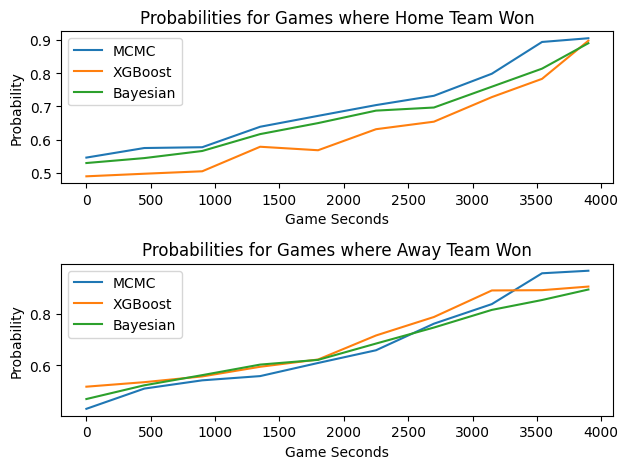

In [45]:
probs_home = avg_probs.loc[avg_probs['home_won'] == 1].copy()
probs_away = avg_probs.loc[avg_probs['home_won'] == 0].copy()

plt.subplot(2,1,1)
plt.title("Probabilities for Games where Home Team Won")
plt.plot(probs_home['game_seconds'], probs_home['mcmc_avg_home_prob'], label='MCMC')
plt.plot(probs_home['game_seconds'], probs_home['xgboost_avg_home_prob'], label='XGBoost')
plt.plot(probs_home['game_seconds'], probs_home['bayesian_avg_home_prob'], label='Bayesian')
plt.xlabel("Game Seconds")
plt.ylabel("Probability")
plt.legend()

probs_away['mcmc_avg_home_prob'] = 1 - probs_away['mcmc_avg_home_prob']
probs_away['xgboost_avg_home_prob'] = 1 - probs_away['xgboost_avg_home_prob']
probs_away['bayesian_avg_home_prob'] = 1 - probs_away['bayesian_avg_home_prob']
probs_away_col_renames = [
    ('mcmc_avg_home_prob', 'mcmc_avg_away_prob'),
    ('xgboost_avg_home_prob', 'xgboost_avg_away_prob'),
    ('bayesian_avg_home_prob', 'bayesian_avg_away_prob')
]
probs_away = probs_away.rename(columns=dict(probs_away_col_renames))

plt.subplot(2,1,2)
plt.title("Probabilities for Games where Away Team Won")
plt.plot(probs_away['game_seconds'], probs_away['mcmc_avg_away_prob'], label='MCMC')
plt.plot(probs_away['game_seconds'], probs_away['xgboost_avg_away_prob'], label='XGBoost')
plt.plot(probs_away['game_seconds'], probs_away['bayesian_avg_away_prob'], label='Bayesian')
plt.xlabel("Game Seconds")
plt.ylabel("Probability")
plt.legend()

plt.tight_layout()
plt.show()



In [48]:
table = predictions.copy()

table['mcmc_correct'] = (table['mcmc'] == table['winner']).astype(int)
table['xgboost_correct'] = (table['xgboost'] == table['winner']).astype(int)
table['bayesian_correct'] = (table['bayesian'] == table['winner']).astype(int)
accuracies = (table
    .groupby(by='game_seconds_table')
    [['mcmc_correct', 'xgboost_correct', 'bayesian_correct']]
    .sum()
    .reset_index()
)
accuracies['games'] = len(table['game_id'].unique())
accuracies['mcmc_accuracy'] = accuracies['mcmc_correct'] / accuracies['games']
accuracies['xgboost_accuracy'] = accuracies['xgboost_correct'] / accuracies['games']
accuracies['bayesian_accuracy'] = accuracies['bayesian_correct'] / accuracies['games']
accuracies = (accuracies
    .drop(columns=['mcmc_correct', 'xgboost_correct', 'bayesian_correct', 'games'])
    .rename(columns={'game_seconds_table': 'game_seconds'}))
accuracies['quarter'] = ['Q1', 'Q1 (1/2)', 'Q2', 'Q2 (1/2)', 'Q3', 'Q3 (1/2)', 'Q4', 'Q4 (1/2)', '1 min to End', 'OT']
accuracies = movecol(accuracies, ['quarter'], 'game_seconds', 'Before')
display(accuracies)

,quarter,game_seconds,mcmc_accuracy,xgboost_accuracy,bayesian_accuracy
0,Q1,0,0.4747475,0.5555556,0.5050505
1,Q1 (1/2),450,0.6161616,0.5454545,0.6060606
2,Q2,900,0.6767677,0.5454545,0.6868687
3,Q2 (1/2),1350,0.6666667,0.6161616,0.7070707
4,Q3,1800,0.7272727,0.5757576,0.6868687
5,Q3 (1/2),2250,0.7272727,0.7171717,0.7575758
6,Q4,2700,0.7878788,0.7676768,0.7979798
7,Q4 (1/2),3150,0.8484848,0.8181818,0.8787879
8,1 min to End,3540,0.9393939,0.8585859,0.9090909
9,OT,3900,0.9595960,0.9292929,1.0000000
